In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [8]:
rfmMoreCut = pd.read_csv('morefeaCut/rfmMoreCUt.csv')
rfmMoreCut=rfmMoreCut.set_index('会员编号')

In [9]:
rfmMoreCut.head()

,money,recent,frequency,sex,age
会员编号,,,,,
1027478498,439.5,4,20,2,21
1030794986,1.0,57,1,1,37
1030797014,248.0,38,15,1,31
1030904479,4.0,50,2,2,36
1033252014,1309.0,39,29,2,36


In [10]:
rfm_log = rfmMoreCut[['money', 'recent','frequency','sex','age']].apply(np.log, axis = 1).round(2)
rfm_log.describe()

,money,recent,frequency,sex,age
count,5314.000000,5314.000000,5314.000000,5314.000000,5314.000000
mean,6.827190,2.693690,3.086415,0.382006,3.464037
std,0.763662,0.943848,0.303960,0.343042,0.237059
min,0.000000,0.000000,0.000000,0.000000,2.400000
25%,6.390000,2.200000,2.940000,0.000000,3.330000
50%,6.880000,3.000000,3.090000,0.690000,3.470000
75%,7.350000,3.430000,3.260000,0.690000,3.610000
max,8.520000,4.090000,4.500000,0.690000,4.810000


In [11]:
rfm_log_zs = (rfm_log -rfm_log.mean())/rfm_log.std()
rfm_log_zs.describe()

,money,recent,frequency,sex,age
count,5.314000e+03,5.314000e+03,5.314000e+03,5.314000e+03,5.314000e+03
mean,1.141361e-14,-6.422429e-14,-4.422106e-14,-6.499714e-14,-8.011991e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.940064e+00,-2.853945e+00,-1.015402e+01,-1.113584e+00,-4.488488e+00
25%,-5.724918e-01,-5.230611e-01,-4.816920e-01,-1.113584e+00,-5.654141e-01
50%,6.915302e-02,3.245329e-01,1.179389e-02,8.978321e-01,2.515615e-02
75%,6.846083e-01,7.801146e-01,5.710779e-01,8.978321e-01,6.157264e-01
max,2.216699e+00,1.479380e+00,4.650561e+00,8.978321e-01,5.677757e+00


In [12]:
from sklearn.metrics import pairwise
class KernelKMeans(object):

    def __init__(self,
                 n_clusters=8,
                 max_iter=300,
                 kernel=pairwise.linear_kernel):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.kernel = kernel

    def _initialize_cluster(self, X):
        self.N = np.shape(X)[0]
        self.y = np.random.randint(low=0, high=self.n_clusters, size=self.N)
        self.K = self.kernel(X)

    def fit_predict(self, X):
        self._initialize_cluster(X)
        for _ in range(self.max_iter):
            obj = np.tile(np.diag(self.K).reshape((-1, 1)), self.n_clusters)
            N_c = np.bincount(self.y)
            for c in range(self.n_clusters):
                obj[:, c] -= 2 * \
                    np.sum((self.K)[:, self.y == c], axis=1) / N_c[c]
                obj[:, c] += np.sum((self.K)[self.y == c][:, self.y == c]) / \
                    (N_c[c] ** 2)
            self.y = np.argmin(obj, axis=1)
        return self.y

In [ ]:
'''
from sklearn.cluster import KMeans
ks = range(1, 17)
inertias = []
kc = KernelKMeans(n_clusters = k,max_iter=100,kernel=lambda X: pairwise.rbf_kernel(X, gamma=0.1))
kc.fit_predict(rfm_log_zs)
'''

In [26]:
clusterNum = 4
model = KernelKMeans(n_clusters = clusterNum, max_iter=100,kernel=lambda X: pairwise.rbf_kernel(X, gamma=0.1))
cluster_labels = model.fit_predict(rfm_log_zs)
rfm_kn = rfmMoreCut.assign(cluster = cluster_labels)
rfm_kn_describe=rfm_kn.groupby('cluster').agg({'money':['mean','count'], 'recent':'mean','frequency':'mean'}).round(2)

<IPython.core.display.Javascript object>


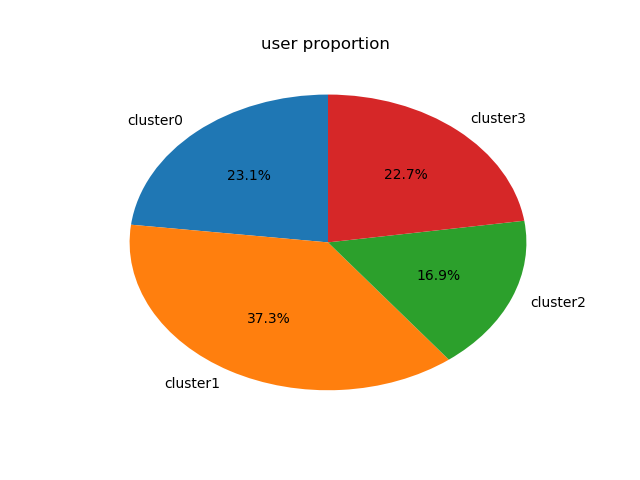

Text(0.5,1,'user proportion ')

In [27]:
# drawing
labels = ['cluster0', 'cluster1','cluster2','cluster3']
sizes = rfm_kn_describe['money']['count'].to_numpy()
explode = (0, 0, 0,0)
plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%', shadow = False, startangle = 90)
plt.title('user proportion ')

<IPython.core.display.Javascript object>


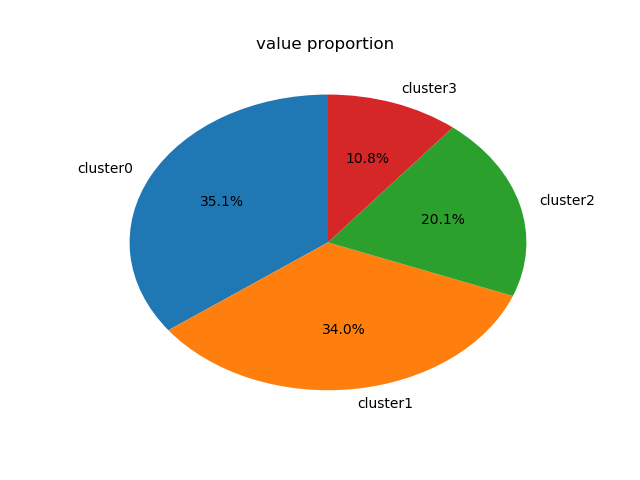

Text(0.5,1,'value proportion ')

In [29]:
customer_sales = rfm_kn.groupby('cluster').agg({'money': 'sum'})
valueSizes = customer_sales['money'].to_numpy()
valueExplode = (0, 0, 0,0)
plt.pie(valueSizes, explode = valueExplode, labels = labels, autopct='%1.1f%%', shadow = False, startangle = 90)
plt.title('value proportion ')

In [30]:
rfm_kn_describe

money       recent frequency
            mean count   mean      mean
cluster                                
0        1809.56  1227  21.15     27.32
1        1082.39  1984  22.96     22.06
2        1411.84   899   3.89     25.04
3         568.43  1204  26.46     18.14

<IPython.core.display.Javascript object>


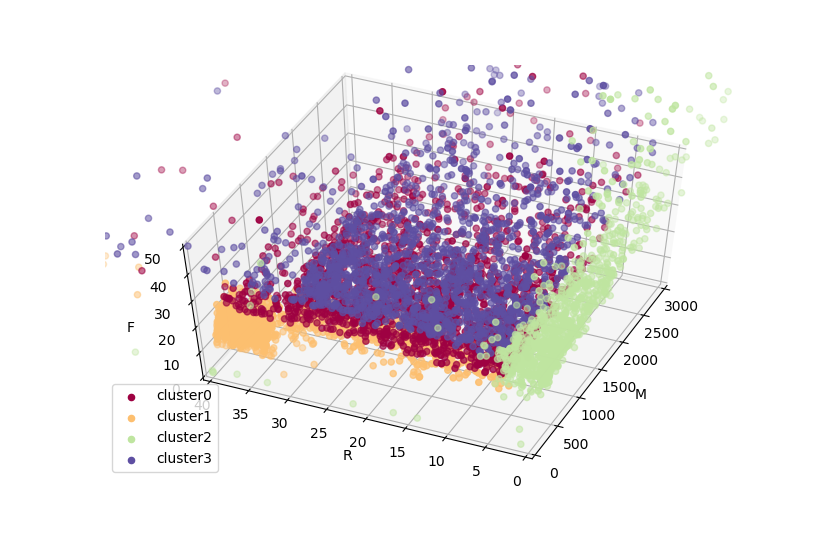

In [17]:
%matplotlib notebook
from mpl_toolkits.mplot3d import proj3d
ax = plt.subplot(111, projection = '3d')
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=3)
for i in range(clusterNum):
    clusterIndex=rfm_kn.loc[rfm_kn['cluster']==i]
    ax.scatter(clusterIndex.iloc[:, 0], clusterIndex.iloc[:, 1], clusterIndex.iloc[:, 2], c = cmap(norm(clusterIndex.iloc[0, 5])),label='cluster{}'.format(i))
ax.set_xlabel('M')
ax.set_xlim([0,3000])
ax.set_ylabel('R')
ax.set_ylim([0,40])
ax.set_zlabel('F')
ax.set_zlim([0, 50])
ax.legend()

In [23]:
clusterNum = 3
model = KernelKMeans(n_clusters = clusterNum, max_iter=100,kernel=lambda X: pairwise.rbf_kernel(X, gamma=0.1))
cluster_labels = model.fit_predict(rfm_log_zs)
rfm_kn = rfmMoreCut.assign(cluster = cluster_labels)
rfm_kn_describe=rfm_kn.groupby('cluster').agg({'money':['mean','count'], 'recent':'mean','frequency':'mean'}).round(2)

<IPython.core.display.Javascript object>


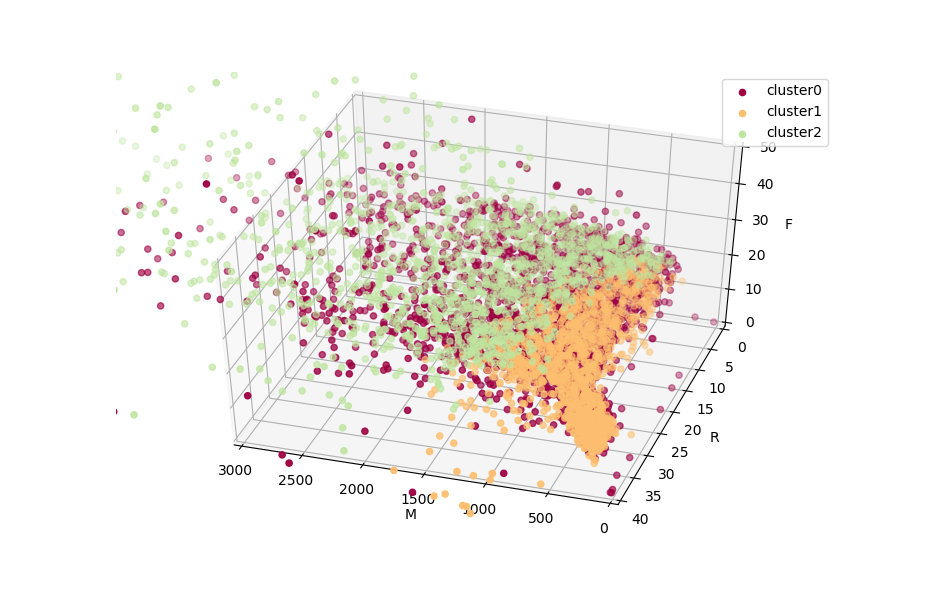

In [22]:

from mpl_toolkits.mplot3d import proj3d
ax = plt.subplot(111, projection = '3d')
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=3)
for i in range(clusterNum):
    clusterIndex=rfm_kn.loc[rfm_kn['cluster']==i]
    ax.scatter(clusterIndex.iloc[:, 0], clusterIndex.iloc[:, 1], clusterIndex.iloc[:, 2], c = cmap(norm(clusterIndex.iloc[0, 5])),label='cluster{}'.format(i))
ax.set_xlabel('M')
ax.set_xlim([0,3000])
ax.set_ylabel('R')
ax.set_ylim([0,40])
ax.set_zlabel('F')
ax.set_zlim([0, 50])
ax.legend()

<IPython.core.display.Javascript object>


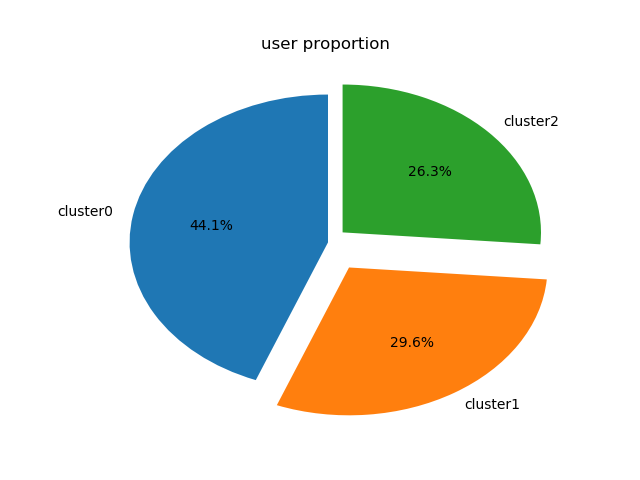

Text(0.5,1,'user proportion ')

In [24]:
# drawing
labels = ['cluster0', 'cluster1','cluster2']
sizes = rfm_kn_describe['money']['count'].to_numpy()
explode = (0, 0.2, 0.1)
plt.pie(sizes, explode = explode, labels = labels, autopct='%1.1f%%', shadow = False, startangle = 90)
plt.title('user proportion ')

<IPython.core.display.Javascript object>


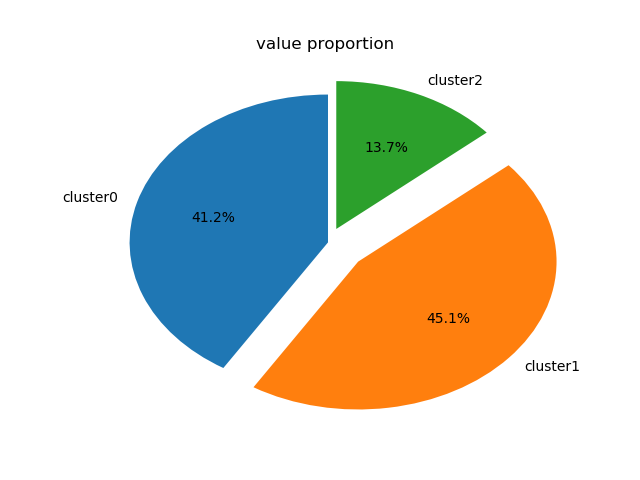

Text(0.5,1,'value proportion ')

In [25]:
customer_sales = rfm_kn.groupby('cluster').agg({'money': 'sum'})
valueSizes = customer_sales['money'].to_numpy()
valueExplode = (0, 0.2, 0.1)
plt.pie(valueSizes, explode = valueExplode, labels = labels, autopct='%1.1f%%', shadow = False, startangle = 90)
plt.title('value proportion ')

In [31]:
rfm_kn_describe

money       recent frequency
            mean count   mean      mean
cluster                                
0        1809.56  1227  21.15     27.32
1        1082.39  1984  22.96     22.06
2        1411.84   899   3.89     25.04
3         568.43  1204  26.46     18.14